# Exploratory Data Analysis (EDA)

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import joblib

# Load the test dataset
test_df = pd.read_csv('dataset/test.csv')

# Function to preprocess the test data
def preprocess_test_data(test_df, scaler=None):
    # Convert columns to appropriate data types
    test_df['humidity'] = pd.to_numeric(test_df['humidity'], errors='coerce')
    test_df['wind_speed'] = pd.to_numeric(test_df['wind_speed'], errors='coerce')
    test_df['pressure'] = pd.to_numeric(test_df['pressure'], errors='coerce')

    # Fill missing panel_age with the median age of the same string_id
    test_df['panel_age'] = test_df.groupby('string_id')['panel_age'].transform(
        lambda x: x.fillna(x.median())
    )

    # Impute missing values for maintenance_count
    error_string_median = test_df.groupby(['string_id', 'error_code'])['maintenance_count'].median()
    error_code_median = test_df.groupby('error_code')['maintenance_count'].median()
    string_id_median = test_df.groupby('string_id')['maintenance_count'].median()
    overall_median = test_df['maintenance_count'].median()

    missing_mask = test_df['maintenance_count'].isna()
    for idx in test_df[missing_mask].index:
        string_id = test_df.loc[idx, 'string_id']
        error_code = test_df.loc[idx, 'error_code']

        if pd.notna(error_code) and (string_id, error_code) in error_string_median:
            test_df.loc[idx, 'maintenance_count'] = error_string_median[(string_id, error_code)]
        elif pd.notna(error_code) and error_code in error_code_median:
            test_df.loc[idx, 'maintenance_count'] = error_code_median[error_code]
        elif string_id in string_id_median:
            test_df.loc[idx, 'maintenance_count'] = string_id_median[string_id]
        else:
            test_df.loc[idx, 'maintenance_count'] = overall_median

    # Impute missing values for soiling_ratio
    maintenance_bins = pd.cut(test_df['maintenance_count'], bins=5, include_lowest=True)
    maintenance_soiling_median = test_df.groupby(maintenance_bins)['soiling_ratio'].median()

    missing_soiling_mask = test_df['soiling_ratio'].isna()
    for idx in test_df[missing_soiling_mask].index:
        maintenance_val = test_df.loc[idx, 'maintenance_count']

        if pd.notna(maintenance_val):
            for bin_range, median_soiling in maintenance_soiling_median.items():
                if maintenance_val >= bin_range.left and maintenance_val <= bin_range.right:
                    test_df.loc[idx, 'soiling_ratio'] = median_soiling
                    break

    # Impute missing values for module_temperature
    if 'temperature' in test_df.columns:
        temp_numeric = pd.to_numeric(test_df['temperature'], errors='coerce')
        module_temp_numeric = pd.to_numeric(test_df['module_temperature'], errors='coerce')

        train_mask = module_temp_numeric.notna() & temp_numeric.notna()
        if train_mask.sum() > 10:
            lr = LinearRegression()
            lr.fit(temp_numeric[train_mask].values.reshape(-1, 1), module_temp_numeric[train_mask])

            predict_mask = module_temp_numeric.isna() & temp_numeric.notna()
            test_df.loc[predict_mask, 'module_temperature'] = lr.predict(temp_numeric[predict_mask].values.reshape(-1, 1))

    numeric_features = test_df.select_dtypes(include=['number']).columns.tolist()
    features_to_use = [f for f in numeric_features if f != 'module_temperature']

    if features_to_use:
        df_numeric = test_df[['module_temperature'] + features_to_use].apply(pd.to_numeric, errors='coerce')
        imputer = KNNImputer(n_neighbors=5)
        imputed_values = imputer.fit_transform(df_numeric)
        test_df['module_temperature'] = imputed_values[:, 0]

    # Create the 'power' feature
    test_df['power'] = test_df['current'] * test_df['voltage']

    # Impute missing values for irradiance
    irradiance = pd.to_numeric(test_df['irradiance'], errors='coerce')
    zero_mask = (irradiance == 0)
    to_impute = zero_mask | irradiance.isna()

    if 'power' in test_df.columns and 'efficiency' in test_df.columns:
        estimated_irradiance = pd.to_numeric(test_df['power'], errors='coerce') / (pd.to_numeric(test_df['efficiency'], errors='coerce') + 0.0001)
        plausible_mask = (estimated_irradiance > 0) & (estimated_irradiance < 1500)
        irradiance[to_impute & plausible_mask] = estimated_irradiance[to_impute & plausible_mask]

    relevant_features = ['temperature', 'module_temperature', 'humidity', 'cloud_coverage']
    use_features = [f for f in relevant_features if f in test_df.columns]

    if use_features:
        knn_data = test_df[use_features].apply(pd.to_numeric, errors='coerce')
        knn_data['irradiance'] = irradiance
        imputer = KNNImputer(n_neighbors=5)
        imputed = imputer.fit_transform(knn_data)
        irradiance[to_impute] = imputed[to_impute, -1]

    irradiance = np.clip(irradiance, 0, 1500)
    if irradiance.isna().any():
        irradiance.fillna(irradiance.median(), inplace=True)
    test_df['irradiance'] = irradiance

    # Impute missing values for humidity
    humidity = pd.to_numeric(test_df['humidity'], errors='coerce')
    zero_mask = (humidity == 0)
    to_impute = zero_mask | humidity.isna()

    relevant_features = ['temperature', 'module_temperature', 'cloud_coverage', 'wind_speed', 'pressure']
    use_features = [f for f in relevant_features if f in test_df.columns]

    if use_features:
        knn_data = test_df[use_features].apply(pd.to_numeric, errors='coerce')
        knn_data['humidity'] = humidity
        imputer = KNNImputer(n_neighbors=5)
        imputed = imputer.fit_transform(knn_data)
        humidity[to_impute] = imputed[to_impute, -1]

    humidity = np.clip(humidity, 0, 100)
    if humidity.isna().any():
        humidity.fillna(humidity.median(), inplace=True)
    test_df['humidity'] = humidity

    # Handle categorical variables: one-hot encode 'error_code'
    test_df = pd.get_dummies(test_df, columns=['error_code'])

    # Ensure all one-hot encoded columns from training are present
    expected_columns = ['error_code_E00', 'error_code_E01', 'error_code_E02', 'error_code_Unknown']
    for column in expected_columns:
        if column not in test_df.columns:
            test_df[column] = 0

    # Scale numerical features using the same scaler as the training data
    if scaler:
        numerical_features = ['module_temperature', 'irradiance', 'power', 'panel_age', 'maintenance_count', 'soiling_ratio', 'humidity']
        test_df[numerical_features] = scaler.transform(test_df[numerical_features])

    return test_df

# Load the scaler used for training data
scaler = joblib.load('scaler.pkl')  # Make sure to replace 'scaler.pkl' with the actual path to your saved scaler

# Preprocess the test data
test_df_processed = preprocess_test_data(test_df, scaler)

# Save the preprocessed test data
test_df_processed.to_csv('test_data_processed.csv', index=False)


/var/folders/pm/1bfdvzwx4pxgpjw04gl_zzc00000gn/T/ipykernel_92841/2930156382.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  maintenance_soiling_median = test_df.groupby(maintenance_bins)['soiling_ratio'].median()


In [41]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import joblib

# Load the test dataset
test_df = pd.read_csv('dataset/test.csv')

# Function to preprocess the test data
def preprocess_test_data(test_df, scaler=None):
    # Convert columns to appropriate data types
    test_df['humidity'] = pd.to_numeric(test_df['humidity'], errors='coerce')
    test_df['wind_speed'] = pd.to_numeric(test_df['wind_speed'], errors='coerce')
    test_df['pressure'] = pd.to_numeric(test_df['pressure'], errors='coerce')

    # Fill missing panel_age with the median age of the same string_id
    test_df['panel_age'] = test_df.groupby('string_id')['panel_age'].transform(
        lambda x: x.fillna(x.median())
    )

    # Impute missing values for maintenance_count
    error_string_median = test_df.groupby(['string_id', 'error_code'])['maintenance_count'].median()
    error_code_median = test_df.groupby('error_code')['maintenance_count'].median()
    string_id_median = test_df.groupby('string_id')['maintenance_count'].median()
    overall_median = test_df['maintenance_count'].median()

    missing_mask = test_df['maintenance_count'].isna()
    for idx in test_df[missing_mask].index:
        string_id = test_df.loc[idx, 'string_id']
        error_code = test_df.loc[idx, 'error_code']

        if pd.notna(error_code) and (string_id, error_code) in error_string_median:
            test_df.loc[idx, 'maintenance_count'] = error_string_median[(string_id, error_code)]
        elif pd.notna(error_code) and error_code in error_code_median:
            test_df.loc[idx, 'maintenance_count'] = error_code_median[error_code]
        elif string_id in string_id_median:
            test_df.loc[idx, 'maintenance_count'] = string_id_median[string_id]
        else:
            test_df.loc[idx, 'maintenance_count'] = overall_median

    # Impute missing values for soiling_ratio
    maintenance_bins = pd.cut(test_df['maintenance_count'], bins=5, include_lowest=True)
    maintenance_soiling_median = test_df.groupby(maintenance_bins)['soiling_ratio'].median()

    missing_soiling_mask = test_df['soiling_ratio'].isna()
    for idx in test_df[missing_soiling_mask].index:
        maintenance_val = test_df.loc[idx, 'maintenance_count']

        if pd.notna(maintenance_val):
            for bin_range, median_soiling in maintenance_soiling_median.items():
                if maintenance_val >= bin_range.left and maintenance_val <= bin_range.right:
                    test_df.loc[idx, 'soiling_ratio'] = median_soiling
                    break

    # Impute missing values for module_temperature
    if 'temperature' in test_df.columns:
        temp_numeric = pd.to_numeric(test_df['temperature'], errors='coerce')
        module_temp_numeric = pd.to_numeric(test_df['module_temperature'], errors='coerce')

        train_mask = module_temp_numeric.notna() & temp_numeric.notna()
        if train_mask.sum() > 10:
            lr = LinearRegression()
            lr.fit(temp_numeric[train_mask].values.reshape(-1, 1), module_temp_numeric[train_mask])

            predict_mask = module_temp_numeric.isna() & temp_numeric.notna()
            test_df.loc[predict_mask, 'module_temperature'] = lr.predict(temp_numeric[predict_mask].values.reshape(-1, 1))

    numeric_features = test_df.select_dtypes(include=['number']).columns.tolist()
    features_to_use = [f for f in numeric_features if f != 'module_temperature']

    if features_to_use:
        df_numeric = test_df[['module_temperature'] + features_to_use].apply(pd.to_numeric, errors='coerce')
        imputer = KNNImputer(n_neighbors=5)
        imputed_values = imputer.fit_transform(df_numeric)
        test_df['module_temperature'] = imputed_values[:, 0]

    # Create the 'power' feature
    test_df['power'] = test_df['current'] * test_df['voltage']

    # Impute missing values for irradiance
    irradiance = pd.to_numeric(test_df['irradiance'], errors='coerce')
    zero_mask = (irradiance == 0)
    to_impute = zero_mask | irradiance.isna()

    if 'power' in test_df.columns and 'efficiency' in test_df.columns:
        estimated_irradiance = pd.to_numeric(test_df['power'], errors='coerce') / (pd.to_numeric(test_df['efficiency'], errors='coerce') + 0.0001)
        plausible_mask = (estimated_irradiance > 0) & (estimated_irradiance < 1500)
        irradiance[to_impute & plausible_mask] = estimated_irradiance[to_impute & plausible_mask]

    relevant_features = ['temperature', 'module_temperature', 'humidity', 'cloud_coverage']
    use_features = [f for f in relevant_features if f in test_df.columns]

    if use_features:
        knn_data = test_df[use_features].apply(pd.to_numeric, errors='coerce')
        knn_data['irradiance'] = irradiance
        imputer = KNNImputer(n_neighbors=5)
        imputed = imputer.fit_transform(knn_data)
        irradiance[to_impute] = imputed[to_impute, -1]

    irradiance = np.clip(irradiance, 0, 1500)
    if irradiance.isna().any():
        irradiance.fillna(irradiance.median(), inplace=True)
    test_df['irradiance'] = irradiance

    # Impute missing values for humidity
    humidity = pd.to_numeric(test_df['humidity'], errors='coerce')
    zero_mask = (humidity == 0)
    to_impute = zero_mask | humidity.isna()

    relevant_features = ['temperature', 'module_temperature', 'cloud_coverage', 'wind_speed', 'pressure']
    use_features = [f for f in relevant_features if f in test_df.columns]

    if use_features:
        knn_data = test_df[use_features].apply(pd.to_numeric, errors='coerce')
        knn_data['humidity'] = humidity
        imputer = KNNImputer(n_neighbors=5)
        imputed = imputer.fit_transform(knn_data)
        humidity[to_impute] = imputed[to_impute, -1]

    humidity = np.clip(humidity, 0, 100)
    if humidity.isna().any():
        humidity.fillna(humidity.median(), inplace=True)
    test_df['humidity'] = humidity

    # Handle categorical variables: one-hot encode 'error_code'
    test_df = pd.get_dummies(test_df, columns=['error_code'])

    # Ensure all one-hot encoded columns from training are present
    expected_columns = ['error_code_E00', 'error_code_E01', 'error_code_E02', 'error_code_Unknown']
    for column in expected_columns:
        if column not in test_df.columns:
            test_df[column] = 0

    # Scale numerical features using the same scaler as the training data
    if scaler:
        numerical_features = ['module_temperature', 'irradiance', 'power', 'panel_age', 'maintenance_count', 'soiling_ratio', 'humidity']
        test_df[numerical_features] = scaler.transform(test_df[numerical_features])

    return test_df

# Load the scaler used for training data
scaler = joblib.load('scaler.pkl')  # Make sure to replace 'scaler.pkl' with the actual path to your saved scaler

# Preprocess the test data
test_df_processed = preprocess_test_data(test_df, scaler)

# Save the preprocessed test data
test_df_processed.to_csv('test_data_processed.csv', index=False)


/var/folders/pm/1bfdvzwx4pxgpjw04gl_zzc00000gn/T/ipykernel_92841/2930156382.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  maintenance_soiling_median = test_df.groupby(maintenance_bins)['soiling_ratio'].median()


In [42]:
# Read the training data
train_data = pd.read_csv('dataset/train.csv')

print("\nDataset Shape:", train_data.shape)
print("\nColumns:", train_data.columns.tolist())
train_data


Dataset Shape: (20000, 17)

Columns: ['id', 'temperature', 'irradiance', 'humidity', 'panel_age', 'maintenance_count', 'soiling_ratio', 'voltage', 'current', 'module_temperature', 'cloud_coverage', 'wind_speed', 'pressure', 'string_id', 'error_code', 'installation_type', 'efficiency']


,id,temperature,irradiance,humidity,panel_age,maintenance_count,soiling_ratio,voltage,current,module_temperature,cloud_coverage,wind_speed,pressure,string_id,error_code,installation_type,efficiency
0,0,7.817315,576.179270,41.24308670850264,32.135501,4.0,0.803199,37.403527,1.963787,13.691147,62.494044,12.82491203459621,1018.8665053152533,A1,NaN,NaN,0.562096
1,1,24.785727,240.003973,1.3596482765960705,19.977460,8.0,0.479456,21.843315,0.241473,27.545096,43.851238,12.012043660984917,1025.6238537572883,D4,E00,dual-axis,0.396447
2,2,46.652695,687.612799,91.26536837560256,1.496401,4.0,0.822398,48.222882,4.191800,43.363708,NaN,1.814399755560454,1010.9226539809573,C3,E00,NaN,0.573776
3,3,53.339567,735.141179,96.19095521176159,18.491582,3.0,0.837529,46.295748,0.960567,57.720436,67.361473,8.736258932034128,1021.8466633134253,A1,NaN,dual-axis,0.629009
4,4,5.575374,12.241203,27.495073003585226,30.722697,6.0,0.551833,0.000000,0.898062,6.786263,3.632000,0.52268384077164,1008.5559577591927,B2,E00,fixed,0.341874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19995,16.868428,NaN,93.53031757838667,14.393967,3.0,0.738911,12.147711,3.005355,26.206810,1.733013,12.594122273332914,1018.3744670739436,B2,E02,tracking,0.664907
19996,19996,53.415061,296.970303,93.98571391279083,25.997012,2.0,0.513061,0.000000,0.532119,65.000000,64.558667,0.9769909288128159,1016.081102065643,D4,E00,fixed,0.354070
19997,19997,2.442727,660.328019,37.9689180401391,32.818396,9.0,0.548602,13.047950,4.075498,11.584869,57.730134,4.750937249871706,1009.6844614602336,D4,NaN,tracking,0.419734
19998,19998,NaN,632.760700,43.01470184078199,19.063517,4.0,NaN,0.000000,1.068906,21.149351,78.123689,11.304158443374758,1006.6738746072241,A1,E00,tracking,0.661963


## Data Summary and Statistics

In [43]:
# Display basic information about the dataset
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  20000 non-null  int64  
 1   temperature         18999 non-null  float64
 2   irradiance          19013 non-null  float64
 3   humidity            20000 non-null  object 
 4   panel_age           18989 non-null  float64
 5   maintenance_count   18973 non-null  float64
 6   soiling_ratio       18990 non-null  float64
 7   voltage             19007 non-null  float64
 8   current             19023 non-null  float64
 9   module_temperature  19022 non-null  float64
 10  cloud_coverage      18990 non-null  float64
 11  wind_speed          20000 non-null  object 
 12  pressure            20000 non-null  object 
 13  string_id           20000 non-null  object 
 14  error_code          14088 non-null  object 
 15  installation_type   14972 non-null  object 
 16  effi

Need to change datatypes of elements which are either float/integer but present as object
i.e Humidity, wind_speed, pressure

In [44]:
# Convert columns from object to numeric types
train_data['humidity'] = pd.to_numeric(train_data['humidity'], errors='coerce')
train_data['wind_speed'] = pd.to_numeric(train_data['wind_speed'], errors='coerce')
train_data['pressure'] = pd.to_numeric(train_data['pressure'], errors='coerce')

After converting these columns, we can verify the changes with `train_data.info()`

In [45]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  20000 non-null  int64  
 1   temperature         18999 non-null  float64
 2   irradiance          19013 non-null  float64
 3   humidity            19873 non-null  float64
 4   panel_age           18989 non-null  float64
 5   maintenance_count   18973 non-null  float64
 6   soiling_ratio       18990 non-null  float64
 7   voltage             19007 non-null  float64
 8   current             19023 non-null  float64
 9   module_temperature  19022 non-null  float64
 10  cloud_coverage      18990 non-null  float64
 11  wind_speed          19881 non-null  float64
 12  pressure            19865 non-null  float64
 13  string_id           20000 non-null  object 
 14  error_code          14088 non-null  object 
 15  installation_type   14972 non-null  object 
 16  effi

In [46]:
# Display statistical summary
train_data.describe()

,id,temperature,irradiance,humidity,panel_age,maintenance_count,soiling_ratio,voltage,current,module_temperature,cloud_coverage,wind_speed,pressure,efficiency
count,20000.000000,18999.000000,19013.000000,19873.000000,18989.000000,18973.000000,18990.000000,19007.000000,19023.000000,19022.000000,18990.000000,19881.000000,19865.000000,20000.000000
mean,9999.500000,25.077241,501.273896,50.066170,17.509758,4.012070,0.698879,16.242251,1.713396,29.923807,51.378575,7.413225,1012.981286,0.510260
std,5773.647028,12.513129,250.926590,28.709656,10.097557,2.002268,0.172244,17.889031,1.152953,12.125405,48.473664,4.329861,10.046245,0.140420
min,0.000000,0.000000,-597.278646,0.010714,0.001264,0.000000,0.400149,0.000000,0.000054,0.000000,0.000244,0.001277,970.087365,0.000000
25%,4999.750000,16.853522,332.227277,25.273574,8.777905,3.000000,0.550654,0.000000,0.772311,21.522124,25.081618,3.668529,1006.187799,0.445613
50%,9999.500000,24.720345,499.654730,50.224152,17.497731,4.000000,0.697663,12.350138,1.558413,29.857669,49.704133,7.396091,1012.906121,0.515709
75%,14999.250000,32.848917,668.416734,74.513994,26.340761,5.000000,0.847838,26.557322,2.474744,38.094943,75.052824,11.158582,1019.786203,0.590324
max,19999.000000,147.394168,1537.810349,99.995202,34.998379,15.000000,0.999949,494.279016,7.315597,65.000000,1000.000000,14.999448,1052.865715,0.987066


## Missing Values Analysis

In [47]:
 # Check missing values
missing_values = train_data.isnull().sum()
missing_pct = (missing_values / len(train_data)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_pct
})
missing_df[missing_df['Missing Values'] > 0]

,Missing Values,Percentage
temperature,1001,5.005
irradiance,987,4.935
humidity,127,0.635
panel_age,1011,5.055
maintenance_count,1027,5.135
soiling_ratio,1010,5.050
voltage,993,4.965
current,977,4.885
module_temperature,978,4.890
cloud_coverage,1010,5.050


## Numerical Features Distribution

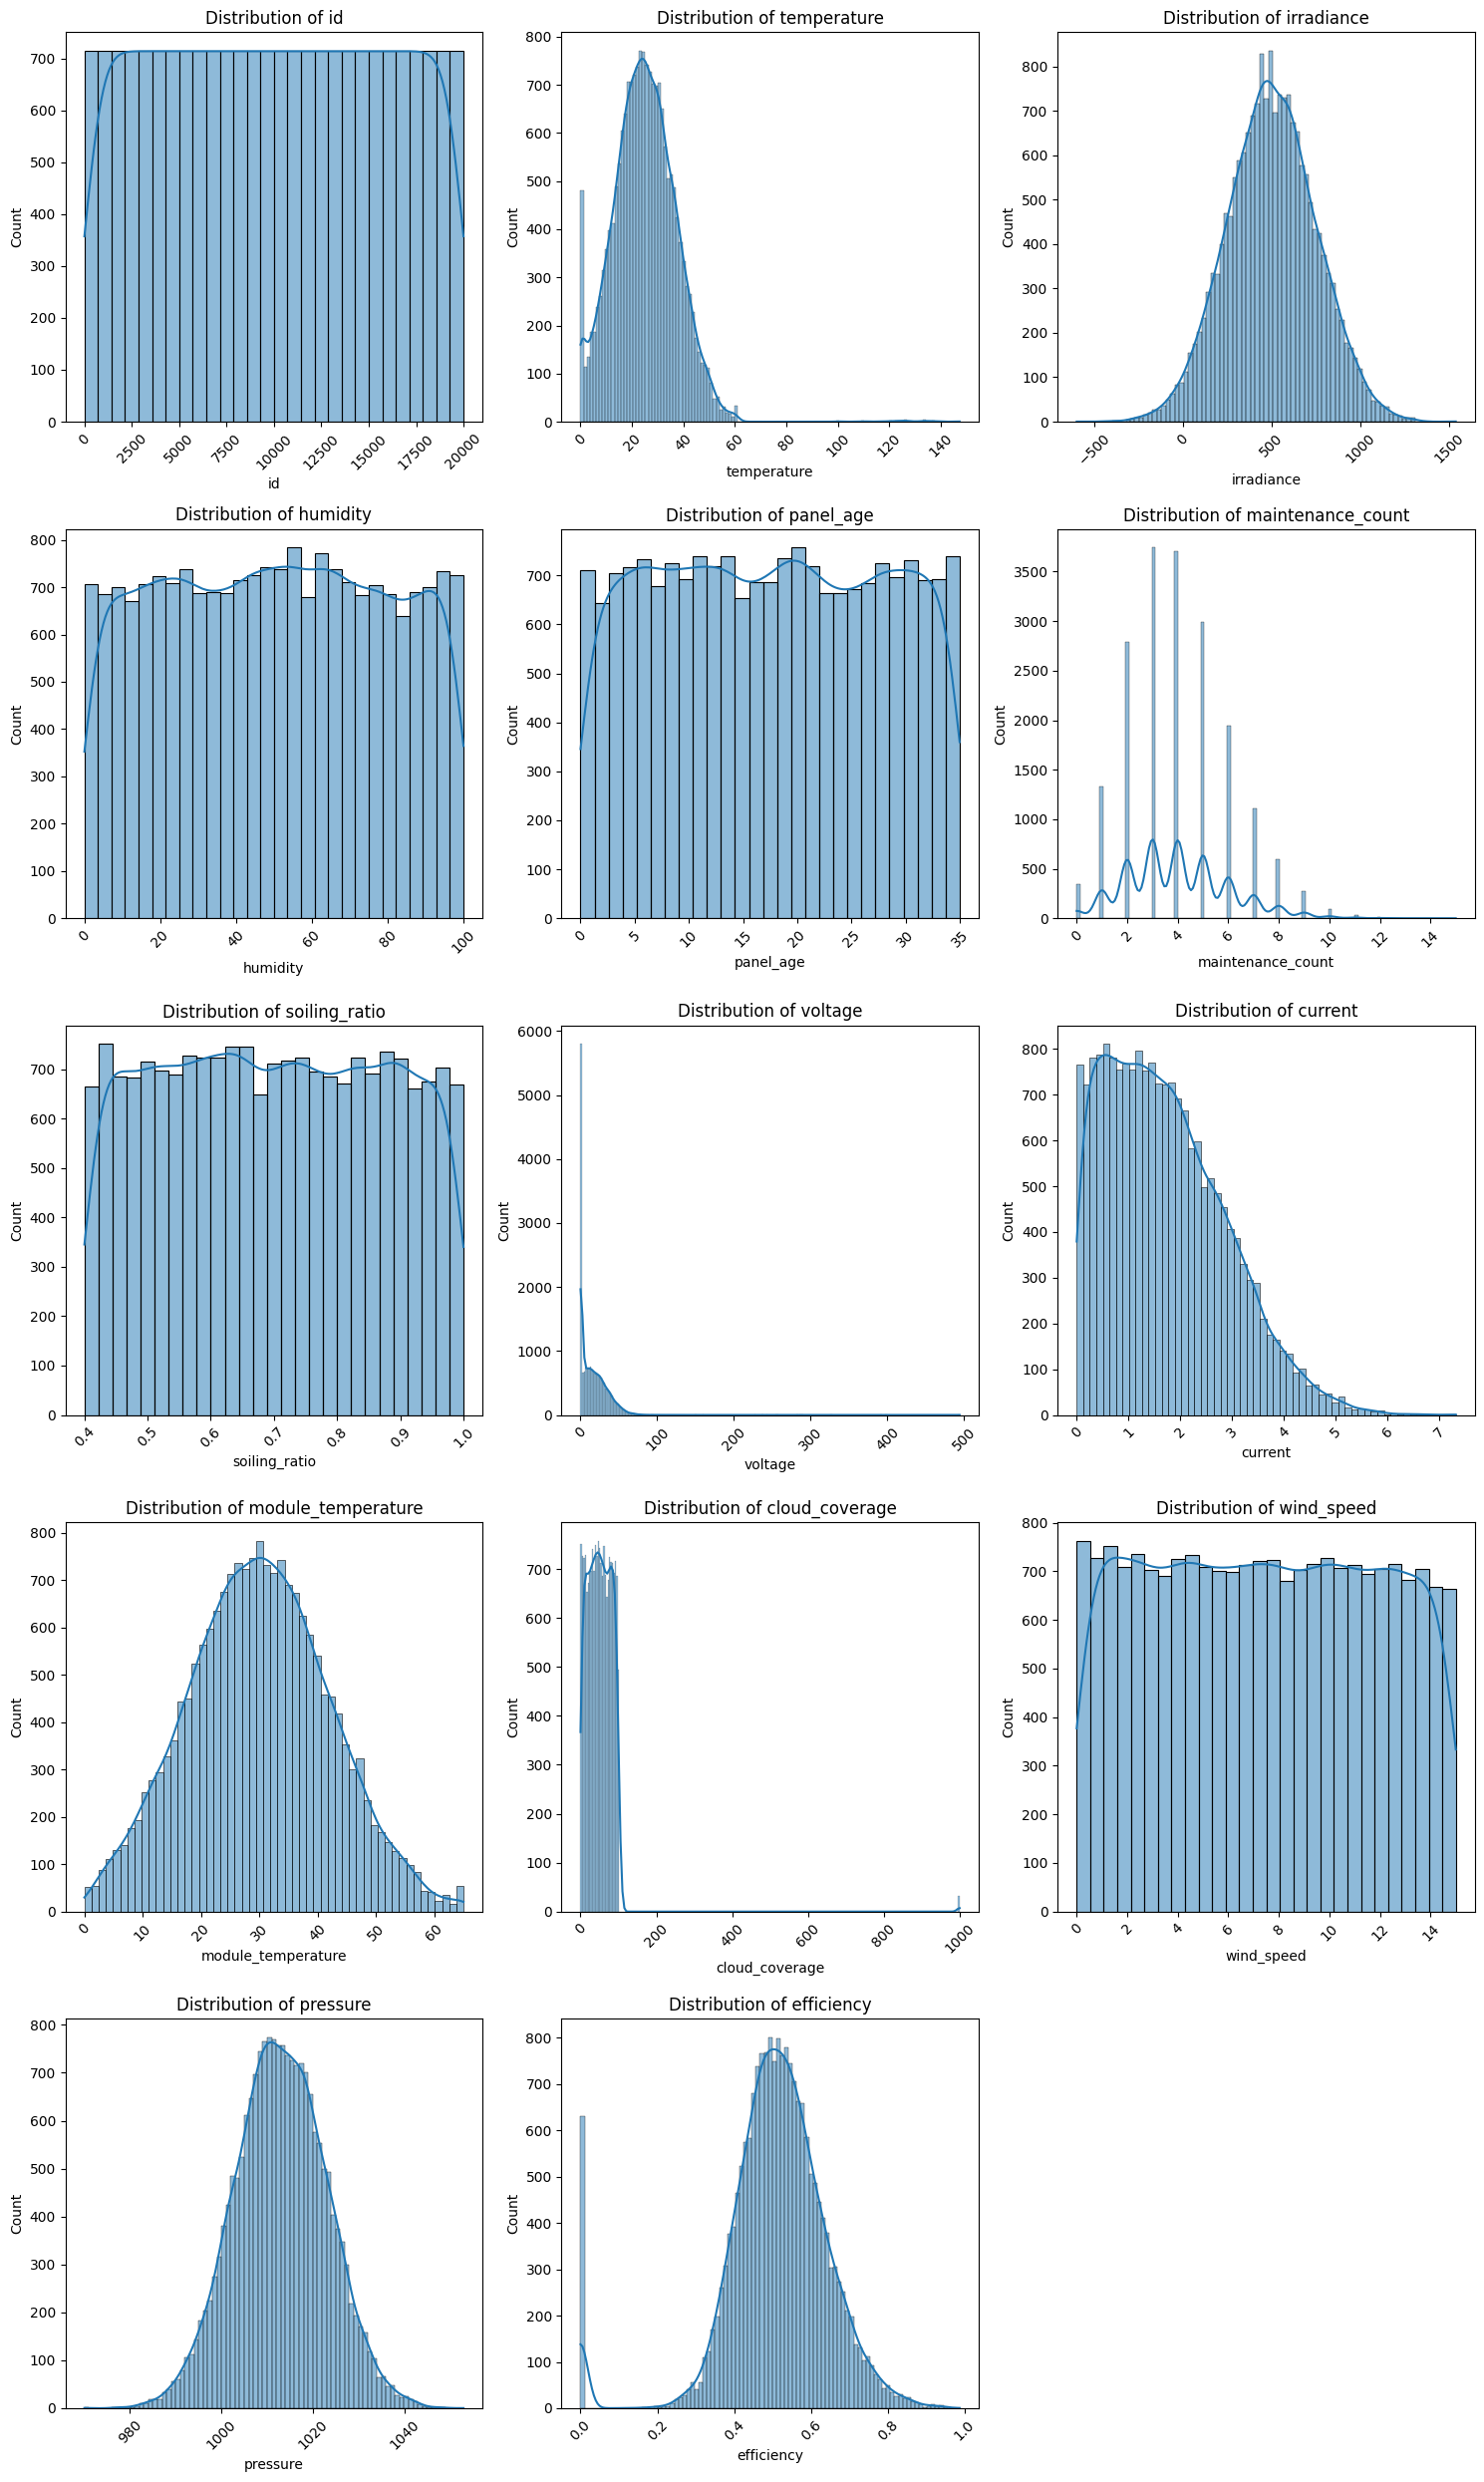

In [48]:
# Select numerical columns
numerical_cols = train_data.select_dtypes(include=['int64', 'float64']).columns

# Create distribution plots for numerical features
plt.figure(figsize=(15, 5 * ((len(numerical_cols) + 2) // 3)))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(((len(numerical_cols) + 2) // 3), 3, i)
    sns.histplot(train_data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Categorical Features Analysis

## Correlation Analysis

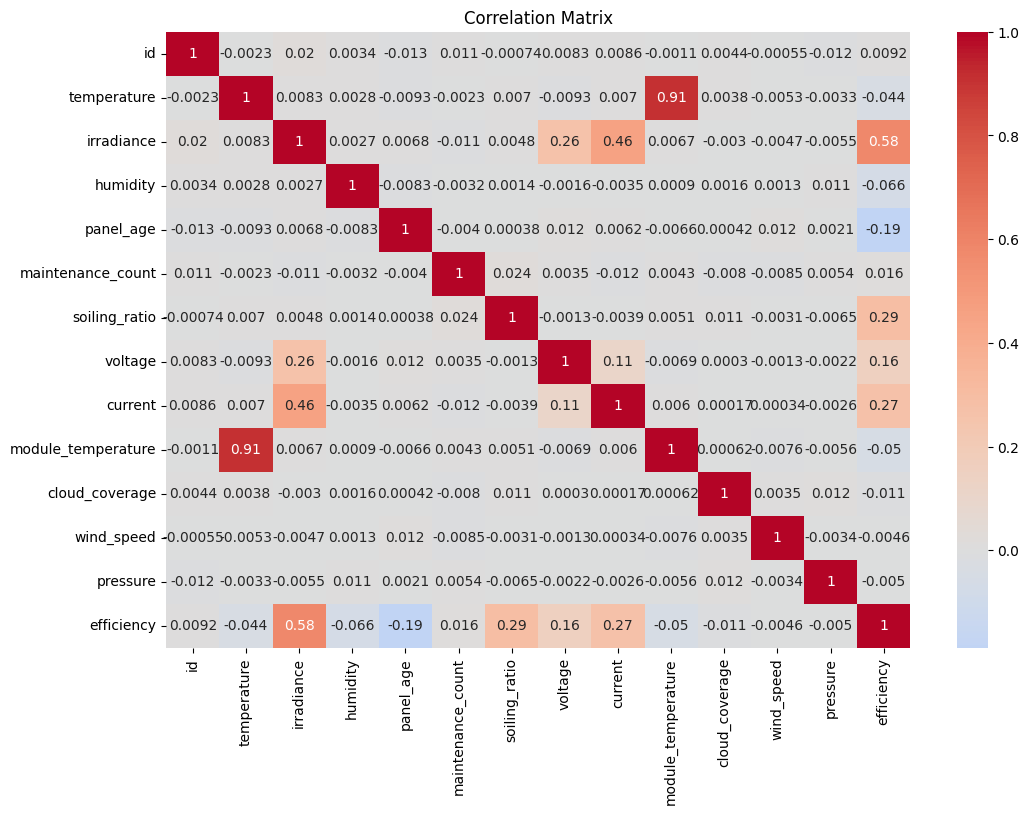

In [49]:
# Calculate correlation matrix for numerical features
correlation_matrix = train_data[numerical_cols].corr()

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()


## Handling Missing Values 
### 1. Panel Age

In [50]:
#number of unique string_ids
train_data.value_counts("string_id")

string_id
D4    5080
B2    5014
C3    5004
A1    4902
Name: count, dtype: int64

In [51]:
# Analyze panel_age by string_id, sorted by missing values
panel_age_analysis = train_data.groupby('string_id')['panel_age'].agg([
    'count',        
    lambda x: x.isnull().sum(), 
    lambda x: (x.isnull().sum() / len(x)) * 100,  # missing percentage
    'mean',       
    'median',        
    'min',             
    'max'              
]).round(2)

# Rename columns for clarity
panel_age_analysis.columns = ['total_panels', 'missing_count', 'missing_pct', 'mean_age', 'median_age', 'min_age', 'max_age']

print("Panel Age Analysis by String ID:")
print("-" * 70)
print(panel_age_analysis)


Panel Age Analysis by String ID:
----------------------------------------------------------------------
           total_panels  missing_count  missing_pct  mean_age  median_age  \
string_id                                                                   
A1                 4662            240         4.90     17.86       17.90   
B2                 4748            266         5.31     17.62       17.64   
C3                 4763            241         4.82     17.31       17.14   
D4                 4816            264         5.20     17.26       17.28   

           min_age  max_age  
string_id                    
A1            0.01    34.99  
B2            0.02    35.00  
C3            0.00    34.99  
D4            0.00    35.00  


Missing percentages are very similar (~5%) across all strings
- Mean ages: 17.26-17.86 years
- All have panels ranging from ~0 to ~35 years
- Medians are close to means (normal distribution)


Since age distributions are similar, we could use group-wise median/mean imputation

Empty DataFrame
Columns: [id, temperature, irradiance, humidity, panel_age, maintenance_count, soiling_ratio, voltage, current, module_temperature, cloud_coverage, wind_speed, pressure, string_id, error_code, installation_type, efficiency]
Index: []


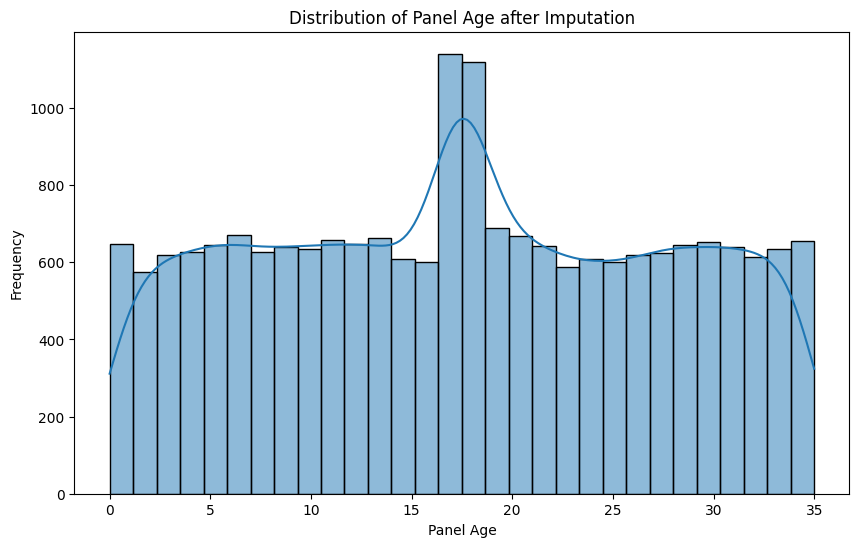

In [52]:
# Fill missing panel_age with the median age of the same string_id
train_data['panel_age'] = train_data.groupby('string_id')['panel_age'].transform(
    lambda x: x.fillna(x.median())
)

# Verify that missing values are filled
print(train_data[train_data['panel_age'].isnull()])

# Check the distribution of panel_age after imputation
plt.figure(figsize=(10, 6))
sns.histplot(train_data['panel_age'], bins=30, kde=True)
plt.title('Distribution of Panel Age after Imputation')
plt.xlabel('Panel Age')
plt.ylabel('Frequency')
plt.show()

### 2. Handling Maintenance Count

In [53]:
train_data.value_counts("error_code")


error_code
E00    5977
E01    4100
E02    4011
Name: count, dtype: int64

Use error_code where available

In [54]:
# STEP 1: Calculate reference values for imputation
print("=== MAINTENANCE COUNT MISSING VALUE IMPUTATION ===")
print(f"Initial missing values: {train_data['maintenance_count'].isna().sum()}")

# 1.1: Combined string_id + error_code median
error_string_median = train_data.groupby(['string_id', 'error_code'])['maintenance_count'].median()
print(f"String+Error combinations: {len(error_string_median)}")

# 1.2: Error code only median
error_code_median = train_data.groupby('error_code')['maintenance_count'].median()
print(f"Error code medians: {len(error_code_median)}")

# 1.3: String ID only median
string_id_median = train_data.groupby('string_id')['maintenance_count'].median()
print(f"String ID medians: {len(string_id_median)}")

# 1.4: Overall median as final fallback
overall_median = train_data['maintenance_count'].median()
print(f"Overall median: {overall_median}")

=== MAINTENANCE COUNT MISSING VALUE IMPUTATION ===
Initial missing values: 1027
String+Error combinations: 12
Error code medians: 3
String ID medians: 4
Overall median: 4.0


In [55]:
# STEP 2: Sequential imputation (hierarchical approach)

# Level 1: Try string_id + error_code combination
missing_mask = train_data['maintenance_count'].isna()
level1_filled = 0

for idx in train_data[missing_mask].index:
    string_id = train_data.loc[idx, 'string_id']
    error_code = train_data.loc[idx, 'error_code']
    
    if pd.notna(error_code) and (string_id, error_code) in error_string_median:
        train_data.loc[idx, 'maintenance_count'] = error_string_median[(string_id, error_code)]
        level1_filled += 1

print(f"Level 1 (String+Error): Filled {level1_filled} values")
print(f"Remaining missing: {train_data['maintenance_count'].isna().sum()}")

Level 1 (String+Error): Filled 713 values
Remaining missing: 314


In [56]:
# Level 2: Fall back to error_code only
missing_mask = train_data['maintenance_count'].isna()
level2_filled = 0

for idx in train_data[missing_mask].index:
    error_code = train_data.loc[idx, 'error_code']
    
    if pd.notna(error_code) and error_code in error_code_median:
        train_data.loc[idx, 'maintenance_count'] = error_code_median[error_code]
        level2_filled += 1

print(f"Level 2 (Error only): Filled {level2_filled} values")
print(f"Remaining missing: {train_data['maintenance_count'].isna().sum()}")

Level 2 (Error only): Filled 0 values
Remaining missing: 314


In [57]:
# Level 3: Fall back to string_id only
missing_mask = train_data['maintenance_count'].isna()
level3_filled = 0

for idx in train_data[missing_mask].index:
    string_id = train_data.loc[idx, 'string_id']
    
    if string_id in string_id_median:
        train_data.loc[idx, 'maintenance_count'] = string_id_median[string_id]
        level3_filled += 1

print(f"Level 3 (String only): Filled {level3_filled} values")
print(f"Remaining missing: {train_data['maintenance_count'].isna().sum()}")

Level 3 (String only): Filled 314 values
Remaining missing: 0


We can also perform below code, but all missing values are filled

In [58]:
# Level 4: Final fallback - overall median
remaining_missing = train_data['maintenance_count'].isna().sum()
if remaining_missing > 0:
    train_data['maintenance_count'] = train_data['maintenance_count'].fillna(overall_median)
    print(f"Level 4 (Overall median): Filled {remaining_missing} values")

print(f"Final missing values: {train_data['maintenance_count'].isna().sum()}")
print("Maintenance count imputation completed!")

Final missing values: 0
Maintenance count imputation completed!


### 3. Handling Soiling Ratio

Strategy: Maintenance-based imputation

Logic: Higher maintenance count indicates dirtier panels (higher soiling ratio)
Implementation:

Group maintenance counts into 5 bins
Use median soiling ratio for each maintenance bin
Fall back to overall median if maintenance count is also missing


Rationale: Strong relationship observed (low maintenance: 0.695 soiling → high maintenance: 0.790 soiling)

In [59]:
# SOILING RATIO IMPUTATION USING MAINTENANCE COUNT
print(f"Initial missing values: {train_data['soiling_ratio'].isna().sum()}")

# Step 1: Create maintenance-based soiling reference
maintenance_bins = pd.cut(train_data['maintenance_count'], bins=5, include_lowest=True)
maintenance_soiling_median = train_data.groupby(maintenance_bins)['soiling_ratio'].median()

print("Maintenance bins and corresponding soiling medians:")
print(maintenance_soiling_median)

# Step 2: Fill missing soiling_ratio based on maintenance_count
missing_soiling_mask = train_data['soiling_ratio'].isna()
filled_count = 0

for idx in train_data[missing_soiling_mask].index:
    maintenance_val = train_data.loc[idx, 'maintenance_count']
    
    if pd.notna(maintenance_val):
        # Find which bin this maintenance value falls into
        for bin_range, median_soiling in maintenance_soiling_median.items():
            if maintenance_val >= bin_range.left and maintenance_val <= bin_range.right:
                train_data.loc[idx, 'soiling_ratio'] = median_soiling
                filled_count += 1
                break

print(f"Filled using maintenance approach: {filled_count} values")

# Step 3: Fill remaining with overall median (if maintenance_count was also missing)
remaining_missing = train_data['soiling_ratio'].isna().sum()
if remaining_missing > 0:
    overall_median = train_data['soiling_ratio'].median()
    train_data['soiling_ratio'] = train_data['soiling_ratio'].fillna(overall_median)
    print(f"Filled remaining with overall median: {remaining_missing} values")

print(f"Final missing values: {train_data['soiling_ratio'].isna().sum()}")

Initial missing values: 1010
Maintenance bins and corresponding soiling medians:
maintenance_count
(-0.016, 3.0]    0.691583
(3.0, 6.0]       0.701549
(6.0, 9.0]       0.704006
(9.0, 12.0]      0.712903
(12.0, 15.0]     0.826882
Name: soiling_ratio, dtype: float64
Filled using maintenance approach: 1010 values
Final missing values: 0


/var/folders/pm/1bfdvzwx4pxgpjw04gl_zzc00000gn/T/ipykernel_92841/3533722664.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  maintenance_soiling_median = train_data.groupby(maintenance_bins)['soiling_ratio'].median()


### 4. Handling Module Temperature

In [60]:
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
import pandas as pd

def impute_module_temperature(train_data):
    """
    Guaranteed imputation of module_temperature missing values
    Returns: train_data with no missing values in module_temperature
    """
    df = train_data.copy()
    
    # STAGE 1: Linear Regression using temperature (best predictor)
    if 'temperature' in df.columns:
        # Convert to numeric, coercing errors to NaN
        temp_numeric = pd.to_numeric(df['temperature'], errors='coerce')
        module_temp_numeric = pd.to_numeric(df['module_temperature'], errors='coerce')
        
        # Get available training data
        train_mask = module_temp_numeric.notna() & temp_numeric.notna()
        if train_mask.sum() > 10:  # Need at least 10 samples
            lr = LinearRegression()
            lr.fit(temp_numeric[train_mask].values.reshape(-1, 1), 
                   module_temp_numeric[train_mask])
            
            # Predict missing values where temperature exists
            predict_mask = module_temp_numeric.isna() & temp_numeric.notna()
            df.loc[predict_mask, 'module_temperature'] = lr.predict(
                temp_numeric[predict_mask].values.reshape(-1, 1))
    
    # STAGE 2: KNN using only numeric features
    if df['module_temperature'].isna().any():
        # Select numeric features only
        numeric_features = df.select_dtypes(include=['number']).columns.tolist()
        features_to_use = [f for f in numeric_features if f != 'module_temperature']
        
        if features_to_use:  # If we have any numeric features to use
            # Convert to numeric, coercing errors to NaN
            df_numeric = df[['module_temperature'] + features_to_use].apply(
                pd.to_numeric, errors='coerce')
            
            imputer = KNNImputer(n_neighbors=5)
            imputed_values = imputer.fit_transform(df_numeric)
            df['module_temperature'] = imputed_values[:, 0]
    
    # STAGE 3: Final guarantee - fill any remaining with median
    if df['module_temperature'].isna().any():
        median_val = pd.to_numeric(df['module_temperature'], errors='coerce').median()
        df['module_temperature'] = pd.to_numeric(df['module_temperature'], errors='coerce')
        df['module_temperature'].fillna(median_val, inplace=True)
    
    # Verify no missing values remain
    assert df['module_temperature'].isna().sum() == 0, "Imputation failed!"
    
    return df

# Usage:
train_data = impute_module_temperature(train_data)

In [61]:
print(f"Final missing values: {train_data['module_temperature'].isna().sum()}")

Final missing values: 0


In [62]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

def add_power_feature(train_data):
    """
    Creates robust power feature (P=IV) handling:
    - Missing values
    - Zero values
    - Non-numeric values
    Returns dataframe with new 'power' column containing no missing values
    """
    # Convert to numeric, treating errors as NaN
    current = pd.to_numeric(train_data['current'], errors='coerce')
    voltage = pd.to_numeric(train_data['voltage'], errors='coerce')
    
    # Create initial power column
    power = current * voltage
    
    # Identify suspicious zeros (where one component is non-zero)
    zero_current_mask = (current == 0) & (voltage != 0)
    zero_voltage_mask = (voltage == 0) & (current != 0)
    suspicious_zeros = zero_current_mask | zero_voltage_mask
    
    # Convert suspicious zeros to NaN for imputation
    power[suspicious_zeros] = np.nan
    
    # Prepare features for imputation
    features = ['irradiance', 'efficiency', 'temperature', 'module_temperature']
    available_features = [f for f in features if f in train_data.columns]
    
    # Create imputation dataframe
    impute_df = pd.concat([
        pd.to_numeric(train_data[f], errors='coerce') for f in available_features
    ], axis=1)
    impute_df['power'] = power
    
    # STAGE 1: KNN Imputation for missing and suspicious zeros
    if impute_df.isna().any().any():
        imputer = KNNImputer(n_neighbors=5)
        imputed_values = imputer.fit_transform(impute_df)
        power = imputed_values[:, -1]  # Last column is power
    
    # STAGE 2: Handle any remaining missing values
    if pd.isna(power).any():
        # Calculate typical current-voltage ratios for fallback
        valid_mask = (current > 0) & (voltage > 0)
        if valid_mask.any():
            median_ratio = (current[valid_mask] / voltage[valid_mask]).median()
            # Estimate power using the median ratio
            power[pd.isna(power)] = np.where(
                current[pd.isna(power)] > 0,
                current[pd.isna(power)] ** 2 / median_ratio,
                voltage[pd.isna(power)] ** 2 * median_ratio
            )
        
        # Final fallback to overall median power
        power[pd.isna(power)] = power[~pd.isna(power)].median()
    
    # Add to dataframe
    train_data['power'] = power
    
    # Verify no missing values
    assert not train_data['power'].isna().any(), "Power imputation failed!"
    
    return train_data

# Usage:
train_data = add_power_feature(train_data)

In [63]:
print(f"Final missing values: {train_data['power'].isna().sum()}")

Final missing values: 0


In [64]:
train_data["power"].head()

0     73.452561
1      5.274577
2    202.140687
3     44.470168
4     45.108059
Name: power, dtype: float64

### 6. Handling Irradiance

In [65]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

def impute_irradiance(train_data):
    """
    Brutally simple irradiance imputation handling:
    - NaN values
    - Zero values
    Returns dataframe with clean irradiance values
    """
    # Make copy to avoid warnings
    df = train_data.copy()
    
    # Convert to numeric, forcing non-numeric to NaN
    irradiance = pd.to_numeric(df['irradiance'], errors='coerce')
    
    # Mark zero values that need imputation (true zeros are rare in irradiance)
    zero_mask = (irradiance == 0)
    
    # Combine zeros and NaN for imputation
    to_impute = zero_mask | irradiance.isna()
    
    # If nothing to impute, return early
    if not to_impute.any():
        df['irradiance'] = irradiance
        return df
    
    # STAGE 1: Use simple physical relationships first
    if 'power' in df.columns and 'efficiency' in df.columns:
        # Estimate irradiance from power = irradiance * efficiency * area
        # Using rough approximation since we don't have panel area
        estimated_irradiance = pd.to_numeric(df['power'], errors='coerce') / \
                             (pd.to_numeric(df['efficiency'], errors='coerce') + 0.0001)
        
        # Fill only physically plausible values
        plausible_mask = (estimated_irradiance > 0) & (estimated_irradiance < 1500)
        irradiance[to_impute & plausible_mask] = estimated_irradiance[to_impute & plausible_mask]
    
    # STAGE 2: KNN imputation with most relevant features
    relevant_features = ['temperature', 'module_temperature', 
                        'humidity', 'cloud_coverage', 'hour_of_day']
    
    # Only use features that exist and have data
    use_features = [f for f in relevant_features if f in df.columns]
    
    if use_features:
        # Prepare data - convert all to numeric
        knn_data = df[use_features].apply(pd.to_numeric, errors='coerce')
        knn_data['irradiance'] = irradiance
        
        # Impute
        imputer = KNNImputer(n_neighbors=5)
        imputed = imputer.fit_transform(knn_data)
        
        # Only update values we wanted to impute
        irradiance[to_impute] = imputed[to_impute, -1]  # Last column is irradiance
    
    # STAGE 3: Final cleanup - replace any remaining bad values
    # Set reasonable physical bounds (0-1500 W/m²)
    irradiance = np.clip(irradiance, 0, 1500)
    
    # If any remain missing (unlikely), fill with median
    if irradiance.isna().any():
        irradiance.fillna(irradiance.median(), inplace=True)
    
    # Update dataframe
    df['irradiance'] = irradiance
    
    # Verify no missing or unreasonable values
    assert not df['irradiance'].isna().any(), "Still has missing values!"
    assert (df['irradiance'] >= 0).all(), "Negative irradiance found!"
    
    return df

# Usage:
train_data = impute_irradiance(train_data)

In [66]:
print(f"Final missing values: {train_data['irradiance'].isna().sum()}")

Final missing values: 0


### 7. Handling Humidity

In [67]:
from sklearn.impute import KNNImputer

def impute_humidity(train_data):
    """
    Imputation handling for humidity:
    - NaN values
    - Zero values
    Returns dataframe with clean humidity values
    """
    # Make a copy to avoid modifying the original dataframe
    df = train_data.copy()

    # Convert to numeric, forcing non-numeric to NaN
    humidity = pd.to_numeric(df['humidity'], errors='coerce')

    # Mark zero values that need imputation
    zero_mask = (humidity == 0)

    # Combine zeros and NaN for imputation
    to_impute = zero_mask | humidity.isna()

    # If nothing to impute, return early
    if not to_impute.any():
        df['humidity'] = humidity
        return df

    # STAGE 1: KNN imputation with most relevant features
    relevant_features = ['temperature', 'module_temperature', 'cloud_coverage', 'wind_speed', 'pressure']

    # Only use features that exist and have data
    use_features = [f for f in relevant_features if f in df.columns]

    if use_features:
        # Prepare data - convert all to numeric
        knn_data = df[use_features].apply(pd.to_numeric, errors='coerce')
        knn_data['humidity'] = humidity

        # Impute
        imputer = KNNImputer(n_neighbors=5)
        imputed = imputer.fit_transform(knn_data)

        # Only update values we wanted to impute
        humidity[to_impute] = imputed[to_impute, -1]  # Last column is humidity

    # STAGE 2: Final cleanup - replace any remaining bad values
    # Set reasonable physical bounds for humidity (0-100%)
    humidity = np.clip(humidity, 0, 100)

    # If any remain missing (unlikely), fill with median
    if humidity.isna().any():
        humidity.fillna(humidity.median(), inplace=True)

    # Update dataframe
    df['humidity'] = humidity

    # Verify no missing or unreasonable values
    assert not df['humidity'].isna().any(), "Still has missing values!"
    assert (df['humidity'] >= 0).all() and (df['humidity'] <= 100).all(), "Humidity out of bounds!"

    return df

# Usage:
train_data = impute_humidity(train_data)


In [68]:
print(f"Final missing values: {train_data['humidity'].isna().sum()}")

Final missing values: 0


### 8. Handling Error Code

In [69]:
import pandas as pd

def impute_error_code(train_data):
    """
    Imputation handling for error_code:
    - Missing values are imputed with a new category 'Unknown'
    Returns dataframe with imputed error_code values
    """
    # Make a copy to avoid modifying the original dataframe
    df = train_data.copy()

    # Directly assign the result of fillna back to the column
    df['error_code'] = df['error_code'].fillna('Unknown')

    return df

# Usage:
train_data = impute_error_code(train_data)


In [70]:
print(f"Final missing values: {train_data['error_code'].isna().sum()}")

Final missing values: 0


## Using IQR to Remove Outliers

In [71]:
# Define the features you want to process
features = ['module_temperature', 'irradiance', 'power', 'panel_age', 'maintenance_count', 'soiling_ratio', 'humidity']

# Function to remove outliers using IQR
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Remove outliers from the train_data
train_data_cleaned = remove_outliers(train_data, features)


In [72]:
# Create a new DataFrame with the cleaned data
cleaned_df = train_data_cleaned[features + ['error_code', 'efficiency']].copy()

In [73]:
cleaned_df.head(5)

,module_temperature,irradiance,power,panel_age,maintenance_count,soiling_ratio,humidity,error_code,efficiency
0,13.691147,576.179270,73.452561,32.135501,4.0,0.803199,41.243087,Unknown,0.562096
1,27.545096,240.003973,5.274577,19.977460,8.0,0.479456,1.359648,E00,0.396447
3,57.720436,735.141179,44.470168,18.491582,3.0,0.837529,96.190955,Unknown,0.629009
4,6.786263,12.241203,45.108059,30.722697,6.0,0.551833,27.495073,E00,0.341874
5,19.392300,174.455123,15.415852,29.853202,5.0,0.962880,86.116835,E00,0.376127


### Encode Categorical Variables

In [74]:
# One-hot encode the 'error_code' column
cleaned_df = pd.get_dummies(cleaned_df, columns=['error_code'])

In [75]:
from sklearn.preprocessing import StandardScaler
import joblib

# Initialize the scaler
scaler = StandardScaler()

# Scale the features
cleaned_df[features] = scaler.fit_transform(cleaned_df[features])
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

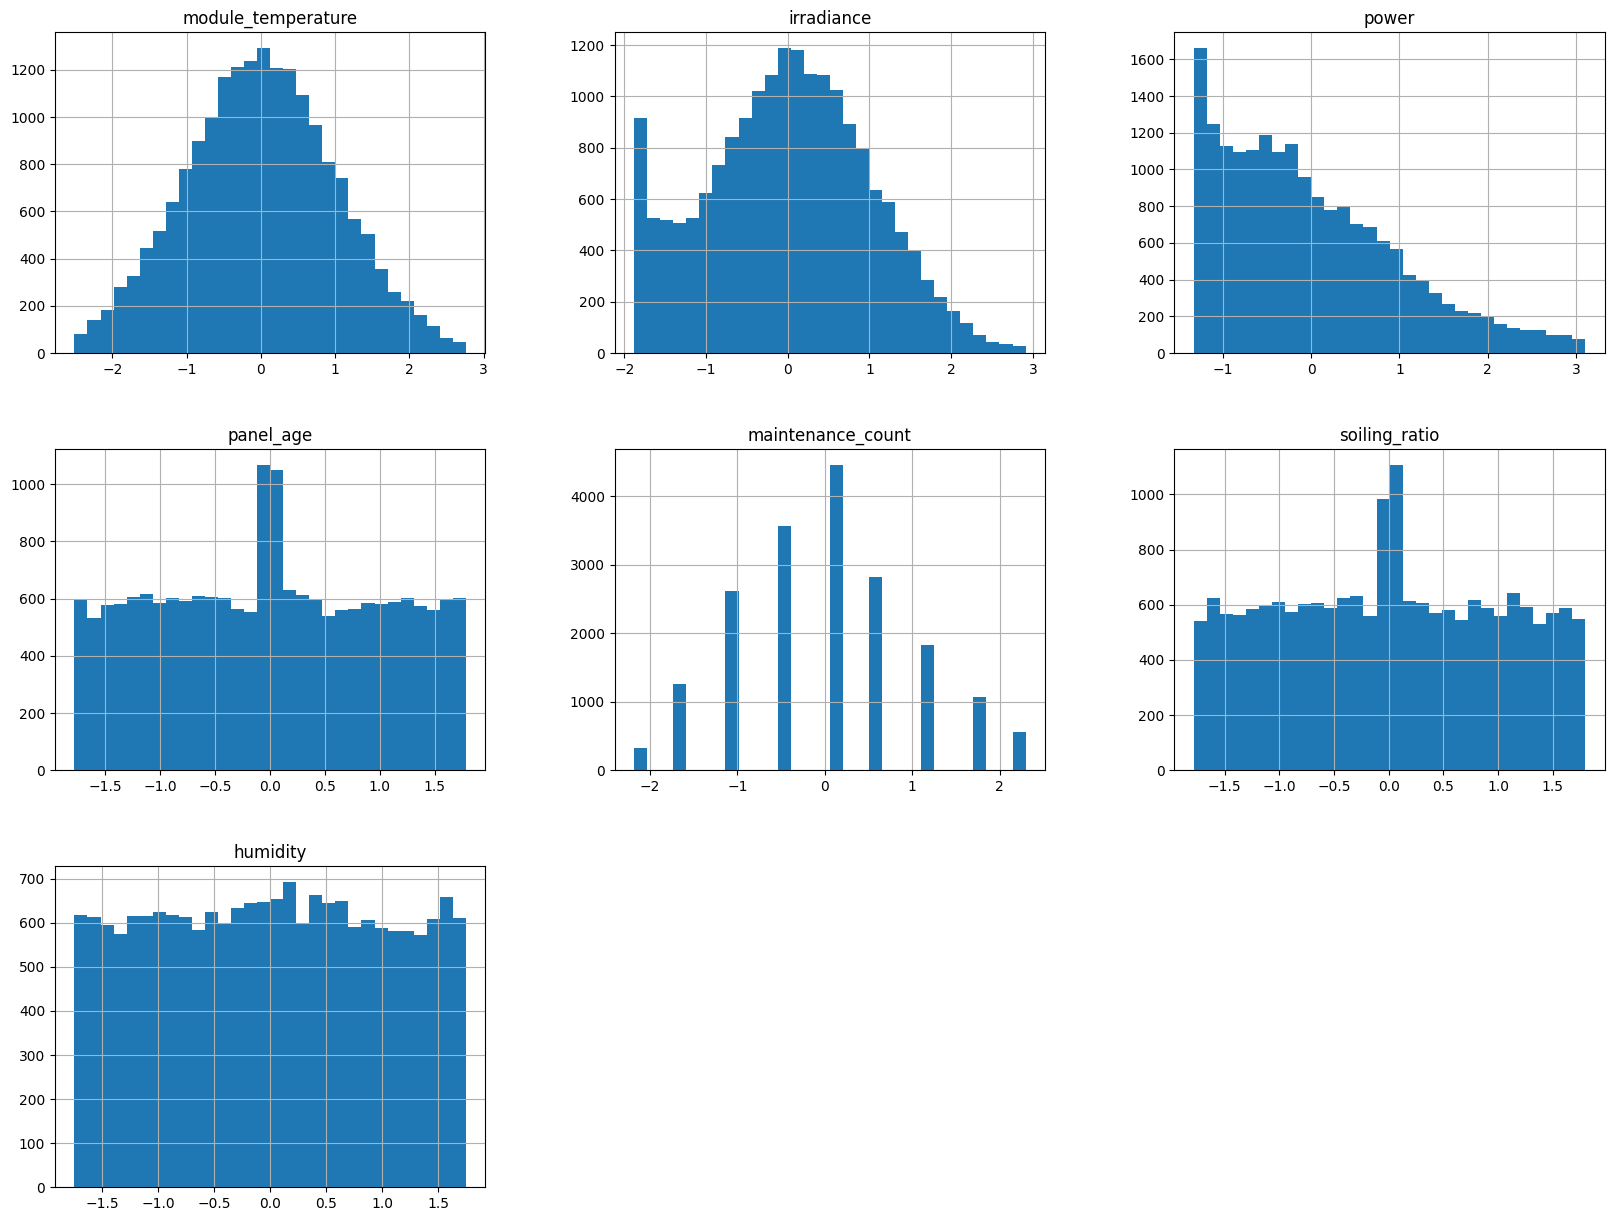

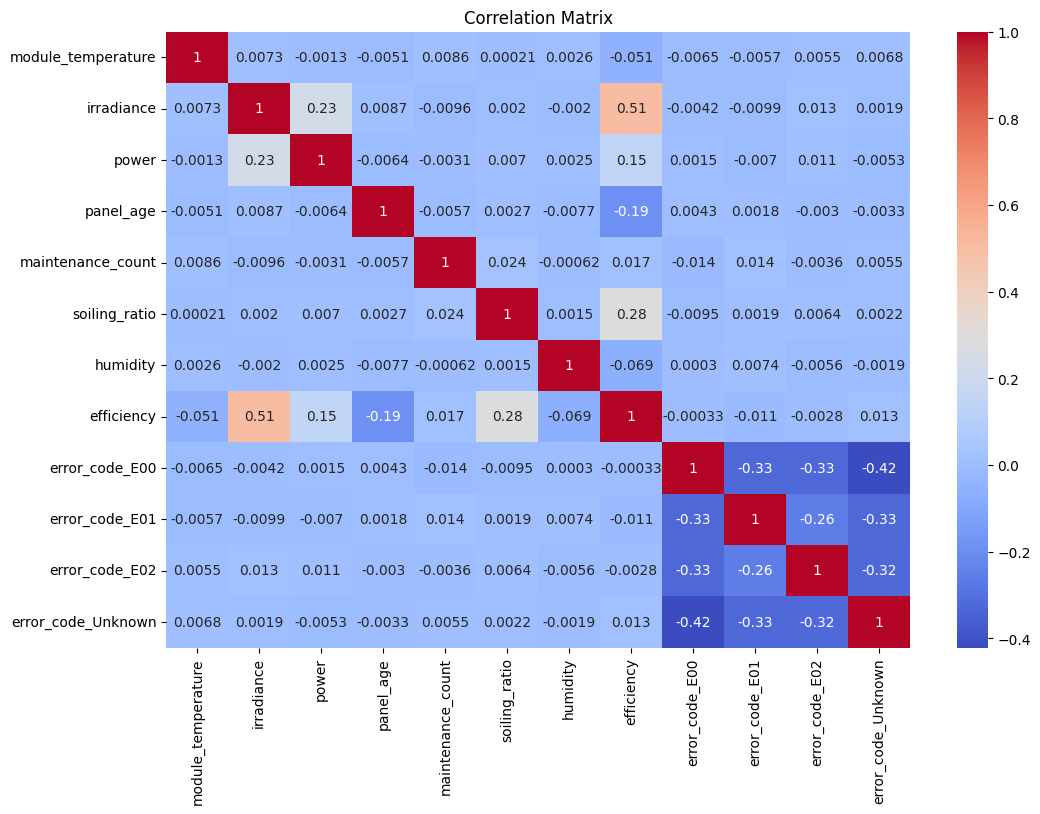

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for numerical features
cleaned_df[features].hist(bins=30, figsize=(20, 15))
plt.show()

# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cleaned_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [77]:
# Save the DataFrame to a CSV file
cleaned_df.to_csv('cleaned_data.csv', index=False)